In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling opencv

In [ ]:
!pip install --upgrade numpy
!pip install --upgrade torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━

Saving 31k1SV8LziL.jpg to 31k1SV8LziL.jpg


Saving images (1).jpeg to images (1) (1).jpeg


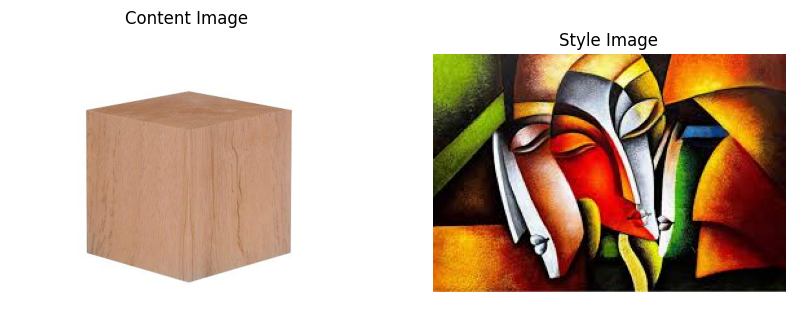

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import vgg19
from PIL import Image
import numpy as np
import cv2
import mediapipe as mp
from google.colab import files
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Upload content and style images
content_file = files.upload()
style_file = files.upload()

content_image = Image.open(list(content_file.keys())[0]).convert('RGB')
style_image = Image.open(list(style_file.keys())[0]).convert('RGB')

# Display uploaded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title('Content Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title('Style Image')
plt.axis('off')
plt.show()


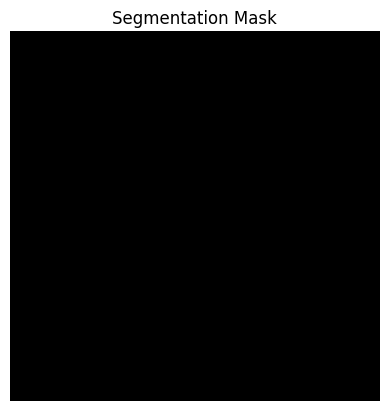

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

# Load pre-trained DeepLabV3 model
model = deeplabv3_resnet50(weights="DEFAULT").to(device)
model.eval()

# Preprocessing function for DeepLabV3
def preprocess_image(image, size=512):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0)

# Postprocessing function to create a binary mask
def decode_segmentation_mask(output):
    # Get the predicted class for each pixel
    output_predictions = output.argmax(0).cpu().numpy()

    # Convert to binary mask (foreground vs background)
    binary_mask = (output_predictions > 0).astype(np.uint8) * 255

    return Image.fromarray(binary_mask)

# Function to perform segmentation with DeepLabV3
def segment_foreground_deeplabv3(image):
    # Convert PIL image to tensor and preprocess
    input_tensor = preprocess_image(image).to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)["out"][0]

    # Decode the segmentation mask
    binary_mask = decode_segmentation_mask(output)

    return binary_mask

# Perform segmentation on the content image
foreground_mask = segment_foreground_deeplabv3(content_image)

# Display the segmentation result
plt.imshow(foreground_mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')
plt.show()


In [ ]:
def preprocess_image(image, size=512, is_mask=False):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    if not is_mask:
        transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    return transform(image).unsqueeze(0)

content_tensor = preprocess_image(content_image)
style_tensor = preprocess_image(style_image)
mask_tensor = preprocess_image(foreground_mask, is_mask=True).to(device)
inverted_mask = 1 - mask_tensor  # Invert the mask to apply style only to the background


In [ ]:
vgg = vgg19(pretrained=True).features
vgg = vgg.to(device)
vgg.eval()

for param in vgg.parameters():
    param.requires_grad_(False)

def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features

content_layers = ['21']  # Use relu4_2
style_layers = ['0', '5', '10', '19', '28']  # Use conv1_1, conv2_1, ..., conv5_1


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 84.1MB/s]


In [ ]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

def content_loss(content_features, target_features):
    return torch.mean((content_features - target_features)**2)

def style_loss(style_features, target_features, weight=1.0):
    gram_style = gram_matrix(style_features)
    gram_target = gram_matrix(target_features)
    return weight * torch.mean((gram_style - gram_target)**2)

def total_variation_loss(image):
    h_tv = torch.mean((image[:,:,1:,:] - image[:,:,:-1,:])**2)
    w_tv = torch.mean((image[:,:,:,1:] - image[:,:,:,:-1])**2)
    return h_tv + w_tv


In [ ]:
def style_transfer(content_img, style_img, mask_img, num_steps=700):
    input_img = content_img.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([input_img], lr=0.02)

    style_weights = {
        '0': 1.0,    # conv1_1
        '5': 0.8,    # conv2_1
        '10': 0.5,   # conv3_1
        '19': 0.3,   # conv4_1
        '28': 0.1    # conv5_1
    }

    content_features = get_features(content_img, vgg, content_layers + list(style_weights.keys()))
    style_features = get_features(style_img, vgg, list(style_weights.keys()))

    for step in range(num_steps):
        features = get_features(input_img, vgg, content_layers + list(style_weights.keys()))

        content_l = content_loss(features[content_layers[0]], content_features[content_layers[0]])

        style_l = 0
        for layer, weight in style_weights.items():
            layer_style_loss = style_loss(features[layer], style_features[layer], weight)
            style_l += layer_style_loss

        tv_l = total_variation_loss(input_img)

        total_loss = content_l + 1e6 * style_l + 1e-5 * tv_l

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if (step + 1) % 50 == 0:
            print(f"Step {step + 1}: Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}")

    with torch.no_grad():
        output = input_img * mask_img + content_img * inverted_mask

    return output


Step 50: Content Loss: 8.1571, Style Loss: 7503060992.0000
Step 100: Content Loss: 9.1936, Style Loss: 4363632128.0000
Step 150: Content Loss: 9.6796, Style Loss: 2430957568.0000
Step 200: Content Loss: 10.0221, Style Loss: 1316908032.0000
Step 250: Content Loss: 10.2506, Style Loss: 856295680.0000
Step 300: Content Loss: 10.3665, Style Loss: 647864640.0000
Step 350: Content Loss: 10.4424, Style Loss: 526026752.0000
Step 400: Content Loss: 10.5189, Style Loss: 442351584.0000
Step 450: Content Loss: 10.5819, Style Loss: 379925312.0000
Step 500: Content Loss: 10.6414, Style Loss: 331341824.0000
Step 550: Content Loss: 10.6919, Style Loss: 292498592.0000
Step 600: Content Loss: 10.7314, Style Loss: 260790432.0000
Step 650: Content Loss: 10.7578, Style Loss: 234388048.0000
Step 700: Content Loss: 10.7825, Style Loss: 212175104.0000


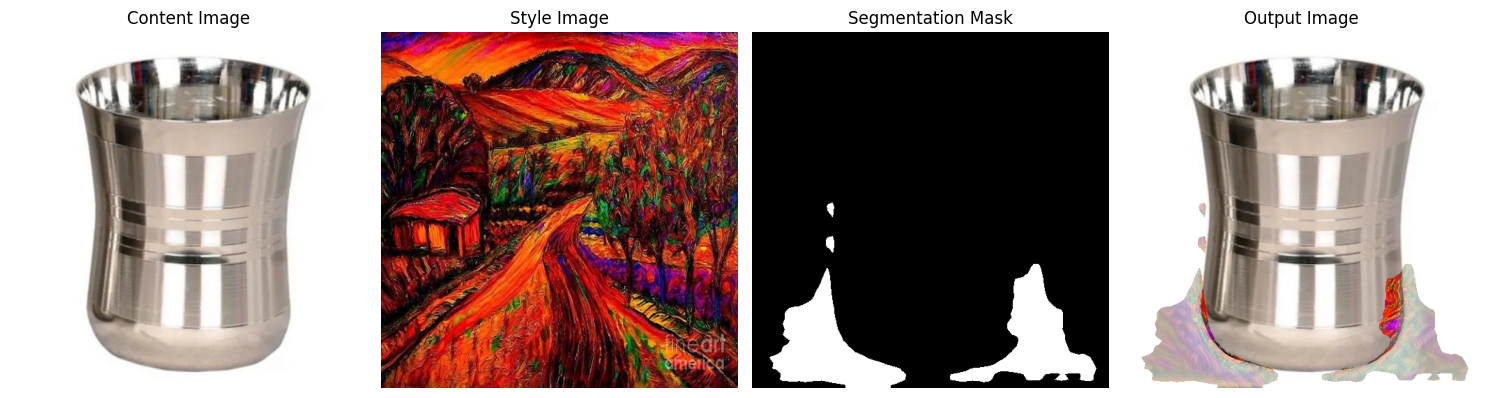

In [ ]:
output = style_transfer(content_tensor.to(device), style_tensor.to(device), mask_tensor.to(device))

def denormalize_image(tensor):
    tensor = tensor.cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)

    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    tensor = tensor.detach() * 255
    tensor = tensor.numpy().transpose(1, 2, 0).astype(np.uint8)
    return Image.fromarray(tensor)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
content_display = denormalize_image(content_tensor.squeeze(0))
plt.imshow(content_display)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 4, 2)
style_display = denormalize_image(style_tensor.squeeze(0))
plt.imshow(style_display)
plt.title('Style Image')
plt.axis('off')

# Display the segmentation result

plt.subplot(1, 4, 3)
plt.imshow(foreground_mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')


plt.subplot(1, 4, 4)
output_display = denormalize_image(output.squeeze(0))
plt.imshow(output_display)
plt.title('Output Image')
plt.axis('off')

plt.tight_layout()
plt.show()

output_display.save('style_transfer_output.png')
